# Facial Keypoint Detector

Made by <a href="https://github.com/SeanvonB">SeanvonB</a> | <a href="https://github.com/SeanvonB/facial-keypoint-detector">Source</a>

This is a project from my [Computer Vision Nanodegree](https://www.udacity.com/course/computer-vision-nanodegree--nd891), which I completed in 2020. It's an exploration of using Convolutional Neural Networks (CNNs) with Haar Cascades to plot facial keypoints (also called "landmarks") on images containing one or more faces. This work provides the foundation for any number of other hypothetical projects, like facial filters, facial tracking, facial pose recognition, emotion recognition, occupancy summation, and so on.

Per Udacity's instruction, the project was broken down into four steps:
1.	Load and visualize data to become familiar with the dataset
2.	Define network architecture and train model
3.	Deploy the model as a facial keypoint detector
4.	Do important data science, i.e. put sunglasses and moustaches on faces

# 1.0 Examine Data

Image data for this project consists of **5,770** full-color stills taken from the [YouTube Faces Database](https://www.cs.tau.ac.il/~wolf/ytfaces/) and turned into sets of one image paired with its associated known keypoints. A random selection of **3,462** images are the **training set**, i.e. the ones used to train new models; and the remaining **2,308** are the **testing set**, i.e. the ones used to test trained models. Their keypoints are stored in `.csv` files that can also be found in the `./data/` directory. Here are a couple examples and their associated keypoints:

<img src='images/example.png' width="100%" height="auto" style="max-width: 800px;">

Oh no, Priyanka – you've got something on your face! Kit, you look fine.

Those pink dots are the keypoints. There are **68** of them, each with their own accessible coordinates, and they identify important facial structures. Each keypoint is individually numbered, and ranges of numbers can be used to select specific facial regions.

<img src='images/keypoints.png' width="100%" height="auto" style="max-width: 800px;"/>

They generally increase left-to-right, and they identify regions as follows:
-    **#1-17** locate the jawline.  
-    **#18-22** and **#23-27** locate eyebrows.  
-    **#28-36** locate regions of the nose.  
-    **#37-42** and **#43-48** locate eyes.  
-    **#49-68** locate regions of the mouth.

This will be important later.

## 1.1 Types of Data

Now, the image data must be retrieved, loaded, and repackaged into a new form that maintains association with the keypoint data.

First, the image data is retrieved and unzipped.

The information about the images and keypoints in this dataset are summarized in `.csv` files, which can be read in using `pandas` (🐼). From the training CSV, and I collect the keypoint annotations as an **(N, 2)** array, where `N` is the number of keypoints and `2` is the dimension of the keypoint coordinates: (x, y).

**Note**: when I mention the dimensions of something, think of those dimensions as the columns and rows of a table. Because that's what they are. If an object has 3 dimensions, you can think of them as a stack of 2-dimensional tables or maybe as a Rubik's cube. Again, that's roughly what they are.

The following will retrieve the image data and unzip it into the `/data/` directory:

In [1]:
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-02-11 20:45:42--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.25.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.25.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.2’

train-test-data.zip 100%[===================>] 322.93M  99.1MB/s    in 3.4s    

2020-02-11 20:45:45 (93.9 MB/s) - ‘/data/train-test-data.zip.2’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


Next, the `.csv` files must be read in by `pandas` (🐼); and, while that's imported, everything else may as well be imported too.

In [2]:
# Import packages
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

Finally, images and known keypoints can be bundled together into the arrays mentioned above.

In [3]:
keypoints_frame = pd.read_csv('/data/training_frames_keypoints.csv')

n = 0
image_name = keypoints_frame.iloc[n, 0]
keypoints = keypoints_frame.iloc[n, 1:].values
keypoints = keypoints.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', keypoints.shape)
print('First 4 key pts: {}'.format(keypoints[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[  45.   98.]
 [  47.  106.]
 [  49.  110.]
 [  53.  119.]]


In [4]:
# Print number of images in training set
print('Number of images: ', keypoints_frame.shape[0])

Number of images:  3462


## 1.2 Check Images

Below, the function `show_keypoints` takes in an image and keypoints and displays them.

This is a good moment to just check out a whole bunch of different images and develop a feel for the dataset and the objective. Important takeaways from this step are that the images are all different shapes and sizes, so they'll have to be normalized in at least a couple different ways.

In [5]:
# Image plot provided by Udacity
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

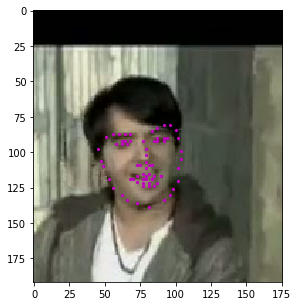

In [6]:
# Select an image from data frame by changing `n`
n = 0
image_name = keypoints_frame.iloc[n, 0]
keypoints = keypoints_frame.iloc[n, 1:].values
keypoints = keypoints.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('/data/training/', image_name)), keypoints)
plt.show()

## 1.3 Dataset Class

The following is a modified version of the Dataset class from [PyTorch](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html) and directions for using it, both provided by Udacity.

>``torch.utils.data.Dataset`` is an abstract class representing a dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.
>
>Your custom dataset should inherit ``Dataset`` and override the following methods:
>
>-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
>-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can be used to get the i-th sample of image/keypoint data.
>Let's create a dataset class for our face keypoints dataset. We will read the CSV file in ``__init__`` but leave the reading of images to ``__getitem__``. This is memory efficient because all the images are not stored in the memory at once but read as required.
>
>A sample of our dataset will be a dictionary ``{'image': image, 'keypoints': key_pts}``. Our dataset will take an optional argument ``transform`` so that any required processing can be applied on the sample. We will see the usefulness of ``transform`` in the next section.

Awesome.

In [7]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # If image has alpha color channel, remove it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

The previous code cell instantiates the dataset, while the following fires off a few random requests to see what the dataset returns.

In [8]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                      root_dir='/data/training/')

print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (180, 159, 3) (68, 2)
1 (227, 196, 3) (68, 2)
2 (315, 271, 3) (68, 2)


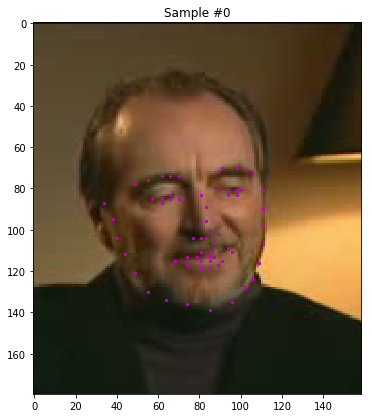

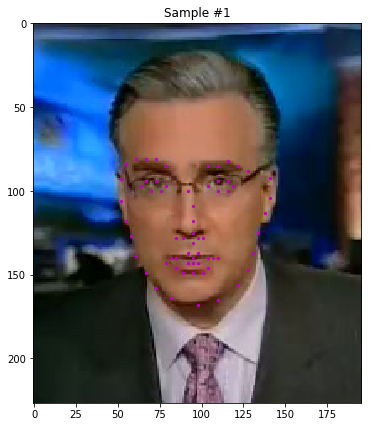

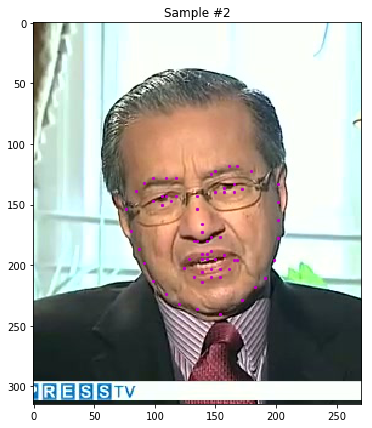

In [9]:
# Display some random images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # Define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # Randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # Print the shape of each image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    show_keypoints(sample['image'], sample['keypoints'])

## 1.4 Transforms

Likewise, Udacity provided some transform functions for preprocessing the images – but I think these may just be copies of `torchvision` functions? Regardless, images need to be preprocessed, because networks expect certain size and dimensions (224x224 seems popular) and particular color normalization. Also, as required by PyTorch, everything created thus far must be converty from NumPy lists and arrays into **Tensors**.

Here's what Udacity provides:

>-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the asssociated keypoints to be within a range of about [-1, 1].
>-  ``Rescale``: to rescale an image to a desired size.
>-  ``RandomCrop``: to crop an image randomly.
>-  ``ToTensor``: to convert numpy images to torch images.
>
>We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it's called. For this, we just need to implement ``__call__`` method and (if we require parameters to be passed in), the ``__init__`` method.
>We can then use a transform like this:
>
>>tx = Transform(params)  
>>transformed_sample = tx(sample)
>
>Observe below how these transforms are generally applied to both the image and its keypoints.

Fabulous.

In [10]:
# Transforms
import torch
from torchvision import transforms, utils

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        keypoints_copy = np.copy(keypoints)

        # Convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Downscale color range from 0-255 to 0-1
        image_copy=  image_copy/255.0
        
        # Downscale keypoints to center around 0 with a range of -1 to 1
        # mean = 100, sqrt = 50; so, points should be (points - 100)/50
        keypoints_copy = (keypoints_copy - 100)/50.0

        return {'image': image_copy, 'keypoints': keypoints_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # Scale the points, too
        keypoints = keypoints * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': keypoints}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        keypoints = keypoints - [left, top]

        return {'image': image, 'keypoints': keypoints}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
         
        # If image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # Add third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # Swap color axis, because
        # NumPy image: H x W x C
        # Torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(keypoints)}

## 1.5 Test the Transforms

This just fires off some transforms to see what they do and whether they do what was expected. They do.

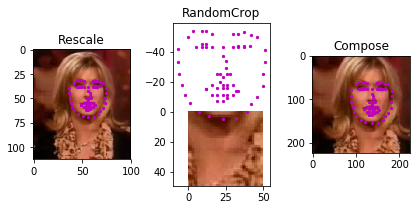

In [11]:
# Test out transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply transforms to sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## 1.6 Create the Transformed Dataset

Finally, the tools are assembled, and the actual dataset (that will be used momentarily for training) can be created. The image is rescaled such that the smaller dimension is 256 pixels, a 224x224 segment is randomly cropped from somewhere within bounds, color normalization and the grayscale filter are applied, and finally the image can be converted to a Tensor.

This `data_transform` pipeline will be used repeatedly throughout this project.

In [12]:
# Define the transform pipeline
data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# Create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

In [13]:
# Print size of dataset
print('Number of images: ', len(transformed_dataset))

# Print size of a few samples
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


# 2.0 Define the Convolutional Neural Network

This section will progress through assembling the model; training the network; benchmarking its performance; and, if it doesn't perform well, repeating the process until it does.

## 2.1 CNN Architecture

Convolutional Neural Networks (CNNs) are comprised of a few specific layers:
- **Convolutional layers**, which abstract details to create a feature map – think of this layer as the eyes converting the image into data that's usable by the brain while sifting out all the background details.
- **Maxpooling layers**, which reduce the size of the image but maintain features by pooling clusters of neurons into single neurons that still represent the cluster.
- **Fully-connected layers**, which are where the "intelligent" stuff happens, like classification or detection – if the previous layers hadn't dramatically downsized the image by this point, these layers could explode into tens of thousands of weights *per neuron*.

I also use **dropout layers**, which help prevent **overfitting**, or when the model can't generalize beyond the training set. Dropout layers do slow down the training process, but – within the safety of this personal project – I can just increase the learnrate and lower the epochs. Reckless training won't crash any autonomous cars here.

The model I build in `model.py` is just a copy of NaimishNet from [this scholarly paper](https://arxiv.org/pdf/1710.00977.pdf), which sounds like I'm being academic, but I'm really just letting someone smarter think for me – thanks, gang! So, the architecture looks something like this:

<img src='images/naimishnet.png' width="100%" height="auto" style="max-width: 400px;"/>

## 2.2 PyTorch Neural Networks

Udacity provides the following notes on using PyTorch:

>To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.
>
>Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.
>
>#### Define the Layers in ` __init__`
>As a reminder, a conv/pool layer may be defined like this (in `__init__`):
>```
># 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
>self.conv1 = nn.Conv2d(1, 32, 3)
>
># maxpool that uses a square window of kernel_size=2, stride=2
>self.pool = nn.MaxPool2d(2, 2)      
>```
>
>#### Refer to Layers in `forward`
>Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
>```
>x = self.pool(F.relu(self.conv1(x)))
>```
>
>Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.
>#### Import model
>
>You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
>```
>    from models import Net
>    net = Net()
>```

Originally, it was important that `model.py` was a separate file, because this used to be multiple Jupyter notebooks and each needed access to it. However, I've since merged all the notebooks, and `model.py` remains more as a vestige of that workflow than as an example of good separation of concerns.

In [2]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np

# Watch for any changes in model.py; if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net

# Print layers
# These are in assignment order, not layer-wise architecture!
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=30976, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## 2.3 Transform the Data 

Again, this appears to already have been done above, but this notebook used to be multiple notebooks and there was some overlap. It doesn't hurt to see the transformation pipeline again; and, this time, it calls from `data_load.py`, which is a better workflow.

What follows are the transforms I defined:

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

# Assemble pipeline
# Removed random rotation (faces are rarely seen sideways or inverted); accuracy was unaffected
data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

assert(data_transform is not None), 'Define a data_transform'

In [5]:
# Transform dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# Print size to confirm
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## 2.4 Batch the Data

Batch size is another one of those hyperparameters that (a) I theoretically understand, but (b) I still just randomly twist the knob up and down. Smaller batch sizes can help a network generalize better, but larger batch sizes will train faster. In my reading, I see many people suggesting **32** as an acceptable all-around size; but, in this case, I had some spare time and dropped the size to **10** – testing improved by an amount so small that it was probably just variance.

Just pop the transformed dataset into PyTorch's [DataLoader](http://pytorch.org/docs/master/data.html).

From Udacity:
>**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

Good note, thanks.

In [6]:
# Load the training set
batch_size = 10
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## 2.5 Load the Test Data

While loading the training set, why not also load the testing set? The **test data** isn't shown to the model during training, as their names imply. Unseen data like this will be the only accurate way to confirm whether the network can accomplish the objective, because the network will have seen contents of the training set many thousands of times by the time training finishes.

In [7]:
# Transform this dataset too
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

In [8]:
# Load the testing set
batch_size = 10
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## 2.6 Apply Model to Test Sample

Currently, the model has random starting weights and isn't remotely "intelligent" yet; but that doesn't mean it can't be given samples!

For some sanity checking, I assembled this pipeline earlier than necessary and passed through a sample, so I could see the base performance of the untrained model. Plus, this step will also help detect leaks in the pipe.

In [9]:
# Test model on batch of test data
def net_sample_output():
    
    # Iterate through dataset
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']

        # Convert image to FloatTensor
        images = images.type(torch.FloatTensor)

        # Feed-forward pass
        net.eval()
        output_pts = net(images)
        net.train()
        
        # Reshape to batch_size x 68 x 2
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # Break rather than continue; one batch is fine
        if i == 0:
            return images, output_pts, key_pts

## 2.7 Debugging

At this point, I was seeing size errors, because the NaimishNet architecture didn't transfer verbatim. The following was helpful for debugging:

In [10]:
# Returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# Print data dimensions to confirm
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## 2.8 Visualize Predicted Keypoints

Udacity provided this `show_all_keypoints` function to visualize both the predicted keypoints (<span style="color:magenta;">pink</span>) and the actual keypoints (<span style="color:green;">green</span>):

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""

    # Image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    # Plot ground truth points as green points
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

But that's not all. Once the model completes the feed-forward process on a sample and returns an inference, the sample remains transformed – it'll need to be ***un*-transformed** before it can be appreciated by human eyeballs.

That's where the following helper function comes in:

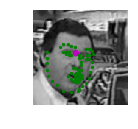

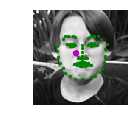

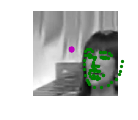

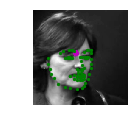

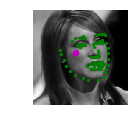

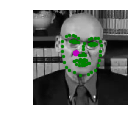

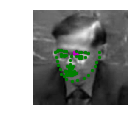

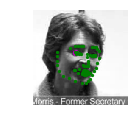

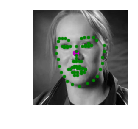

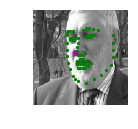

In [12]:
# Visualize output by plotting both predicted keypoints and actual keypoints
def visualize_output(test_images, test_outputs, actual=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # Un-transform the data
        image = test_images[i].data
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        predicted_keypoints = test_outputs[i].data
        predicted_keypoints = predicted_keypoints.numpy()
        predicted_keypoints = predicted_keypoints*50.0+100
        
        # Plot actual keypoints if known
        actual_keypoints = None
        if actual is not None:
            actual_keypoints = actual[i]         
            actual_keypoints = actual_keypoints*50.0+100
        
        # Call helper function to display
        show_all_keypoints(np.squeeze(image), predicted_keypoints, actual_keypoints) 
        plt.axis('off')
        
    plt.show()
visualize_output(test_images, test_outputs, gt_pts)

Alright, cool – so, when the model doesn't yet know any better, it just places all the keypoints in the center. That's interesting.

## 2.9 Loss Function and Optimizer

All that remains before training the network is setting the loss function and optimizer and defining the hyperparameters.

In my [image classifier](https://seanvonb.github.io/image-classifier/), **cross entropy loss** was the obvious choice for a classification task, i.e. one that produces many outputs each equal to the probability of something being true. However, in a regression task like this one, there will only be two outputs per keypoint: an `x` coordinate and a `y` coordinate. According to [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html), regression can use **mean squared error** (or MSE) instead.

As for the optimizer, **Adam** was a good friend in high school, so I always give him a chance first. Yee, boi!

In [13]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

## 2.10 Training

At this point, everything has been explained – probably more than once! But some guesswork does remain. I always start with just a few epochs to save time and determine whether everything works before finally jumping up to 20 epochs for the real run. See you on the other side!

In [14]:
def train_net(n_epochs):
    net.train()

    for epoch in range(n_epochs):
        running_loss = 0.0

        # For each batch...
        for batch_i, data in enumerate(train_loader):
            # Get image and actual keypoints
            images = data['image']
            actual_keypoints = data['actual_keypoints']

            # Flatten them
            actual_keypoints = actual_keypoints.view(actual_keypoints.size(0), -1)

            # Convert them to floats for MSE
            actual_keypoints = actual_keypoints.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # Feed forward to produce prediction
            predicted_points = net(images)

            # Calculate loss between predicted and actual keypoints
            loss = criterion(predicted_points, actual_keypoints)

            # Zero the weight gradients
            optimizer.zero_grad()
            
            # Backward pass to recalculate gradients
            loss.backward()

            # Update weights
            optimizer.step()

            # Print running results
            running_loss += loss.item()
            if batch_i % 10 == 9:    # Every 10 batches
                print('Epoch: {:<2} Batch: {:<3} Loss: {:0.3f}'.format(epoch+1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')

In [15]:
# Number of training cycles
n_epochs = 20

# Run training
train_net(n_epochs)

Epoch: 1  Batch: 10  Loss: 0.560
Epoch: 1  Batch: 20  Loss: 0.439
Epoch: 1  Batch: 30  Loss: 0.387
Epoch: 1  Batch: 40  Loss: 0.341
Epoch: 1  Batch: 50  Loss: 0.362
Epoch: 1  Batch: 60  Loss: 0.305
Epoch: 1  Batch: 70  Loss: 0.323
Epoch: 1  Batch: 80  Loss: 0.265
Epoch: 1  Batch: 90  Loss: 0.278
Epoch: 1  Batch: 100 Loss: 0.292
Epoch: 1  Batch: 110 Loss: 0.295
Epoch: 1  Batch: 120 Loss: 0.297
Epoch: 1  Batch: 130 Loss: 0.297
Epoch: 1  Batch: 140 Loss: 0.246
Epoch: 1  Batch: 150 Loss: 0.290
Epoch: 1  Batch: 160 Loss: 0.248
Epoch: 1  Batch: 170 Loss: 0.253
Epoch: 1  Batch: 180 Loss: 0.219
Epoch: 1  Batch: 190 Loss: 0.321
Epoch: 1  Batch: 200 Loss: 0.247
Epoch: 1  Batch: 210 Loss: 0.223
Epoch: 1  Batch: 220 Loss: 0.203
Epoch: 1  Batch: 230 Loss: 0.233
Epoch: 1  Batch: 240 Loss: 0.335
Epoch: 1  Batch: 250 Loss: 0.214
Epoch: 1  Batch: 260 Loss: 0.262
Epoch: 1  Batch: 270 Loss: 0.243
Epoch: 1  Batch: 280 Loss: 0.228
Epoch: 1  Batch: 290 Loss: 0.244
Epoch: 1  Batch: 300 Loss: 0.235
Epoch: 1  

## 2.11 Testing

The previous training routine took about 2 hours to complete, but I ran some variation of the last couple steps several times before accepting this model. Below, you'll find the results of this test – remember: the <span style="color:magenta;">pink</span> points are predicted by the model, while the <span style="color:green;">green</span> points are the actual, known keypoints.

In [16]:
# Get another test sample
test_images, test_outputs, actual_keypoints = net_sample_output()

# Print size
print(test_images.data.size())
print(test_outputs.data.size())
print(actual_keypoints.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


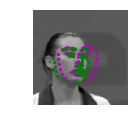

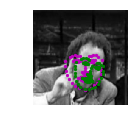

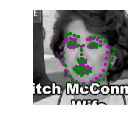

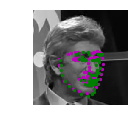

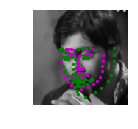

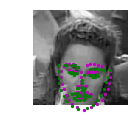

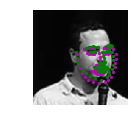

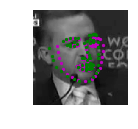

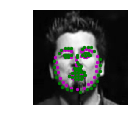

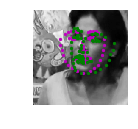

In [17]:
# Plot image and both sets of points
visualize_output(test_images, test_outputs, actual_keypoints)

Uh-oh, I still see some signs of overfitting. Notice how the predicted points tend to be slightly more centralized than the actual keypoints, or how the predicted points don't deform their structure quite as much when the face isn't looking directly into the camera?

This was a pretty good showing, however; I definitely saw worse on previous runs. So, I'll move on to...

## 2.12 Save the Model

In [18]:
# Change `model_name` or previous model will be overwritten
model_dir = 'models/'
model_name = 'keypoints_model_1.pt'

torch.save(net.state_dict(), model_dir+model_name)

## 2.13 Nanodegree Questions

The following are questions that I had to answer when submitting this project to Udacity for my Computer Vision Nanodegree:

#### Question 1: What optimization and loss functions did you choose and why?

**Answer**: I used Adam, because it seems to be the latest hotness that all the gals down in Stack Overflow are talking about. For loss function, I used MSE, but I don't know whether it was an impactful choice – all I know is that it had to be a function suitable to a regression problem.

#### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: My network is based on the NaimishNet example, because I doubt that I can do better than people who have dedicated their lives to the study of this subject. Oh, wait, I actually did try to do better! I added fully-connected layers to NaimishNet, but they only increased overfitting. Today I Learned.

#### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: From what I can tell, 20 epochs seems to be an accepted standard for a proof of concept. I chose a batch size of 10, because smaller batches have been shown to improve a model's ability to generalize. But I've since observed that batch sizes that are divisible by 8 seem to be more fashionable; so, in the future, I'll probably default to 16 or 32.

#### Question 4: Choose one filter from your trained CNN; what purpose do you think it plays? What kind of feature do you think it detects?

**Answer**: The first filter (index=0) doesn't do anything dramatic – it's really just a gentle blur. However, I wonder whether mild filters like this one are also beneficial; perhaps they preserve certain features for extraction by subsequent layers.

## 2.14 Feature Visualization

Now that I have a "working" model, the first thing I wanna do is jump into those guts and see what's happening inside. Aren't you curious what these images look like after they've been transformed, convoluted, and maxpooled? Let's take a look at what's going on inside a CNN.

First, an example of what a convolution filter looks like:

[[-0.04707267 -0.0583389   0.19476311  0.05585203 -0.17116383]
 [-0.00840306 -0.06657861  0.07488757  0.15785611  0.16470772]
 [ 0.11142143  0.20647456 -0.11074037  0.15031649 -0.17609671]
 [ 0.05433566  0.02660246  0.07823772  0.14658174  0.03625878]
 [ 0.13994598  0.07088993 -0.06875328 -0.00787444 -0.11447631]]
(5, 5)


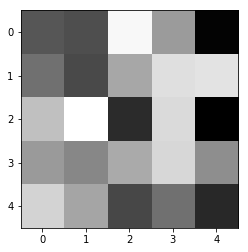

In [19]:
# Get weights of first conv layer, "conv1"
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# Plot weights
plt.imshow(w[filter_index][0], cmap='gray')

This little 5x5 block slides left-to-right, top-to-bottom across the image, multiplying the pixels underneath. That seemingly random pattern might highlight important features and/or reduce everything else to a featureless gray soup. The end result of this filtering process is called a **feature map** and can look something like this:

<img src='images/feature_map.png' width="100%" height="auto" style="max-width: 800px;"/>

This particular feature map might function as edge detection for a light source originating from the top-left corner, but feature maps aren't created intentionally or with such clear purpose. Basically, the network values this feature map ***for some reason***, because the filter weights were incrementally shifted until this map was created – but I can only speculate why.

# 3.0 Face and Facial Keypoint Detection

Now that the network has been trained and proven (somewhat) effective through testing, it can apply facial keypoints to *any* image – for proper function, that image ought to include at least one human face, but I suppose you're free to confuse the network by passing something else through.

However, the network currently know how to detect ***facial keypoints***; it doesn't know how to detect ***faces*** yet. This dataset had already been preproccessed in such a way that the faces contained within were more or less the focal point of the image. And what about images with more than one face?

In section 3, the pipeline will be extended to include the following:
1.	Detect every face within an image using a face detector, so those faces can be cropped out of the original image
2.	Preprocess those cropped samples into the format the network expects, i.e. grayscale Tensors of size 224x224
3.	Apply the trained model and be amazed!

Let's get back into it...

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

The following will display the selected image (again, you could replace this with any image at this point), completely unprocessed:

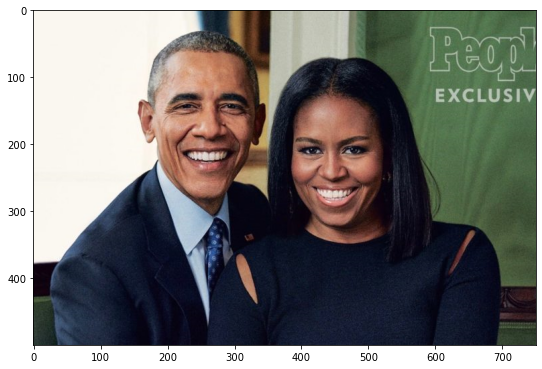

In [2]:
import cv2
# Load new color image from image directory
image = cv2.imread('./images/obamas.jpg')

# Switch red and blue, because OpenCV uses BGR, not RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

Looking good, Obamas!

## 3.1 Detect All Faces

In order to detect where exactly their faces are, or even how many faces there are, I'm using a pre-trained Haar Cascade detector via [OpenCV](https://opencv.org/). The detector I'm using is located in the `./detectors/` directory and works by using tiny 2x2 and 3x3 filters like these, which are called **Haar features**:

<img src='images/haar_features.png' width="100%" height="auto" style="max-width: 320px;"/>

Unlike the filter shown above, you'll notice that Haar features are strictly 100% or 0% – there are no shades of gray. They also have specific, prescribed patterns, which are useful for locating the edges of shapes in images.

It's called a Haar ***Cascade*** detector, because it uses a ***cascade*** of classifiers that all use Haar features. So, rather than constantly running and re-running thousands of "**is this a face?**" checks, the cascade begins by running a few "**could this region possibly contain a face?**" checks. If the region can't, then the detector tosses out that region and moves on to the next. But, if the region can, the cascade continues through a series of other classifiers that check for increasingly specific indicators that a face is present – if any of these fail, the detector tosses it out and moves on again.

Here's an example of successful Haar Cascade detection:

<img src='images/haar_cascade.png' width="100%" height="auto" style="max-width: 800px;"/>

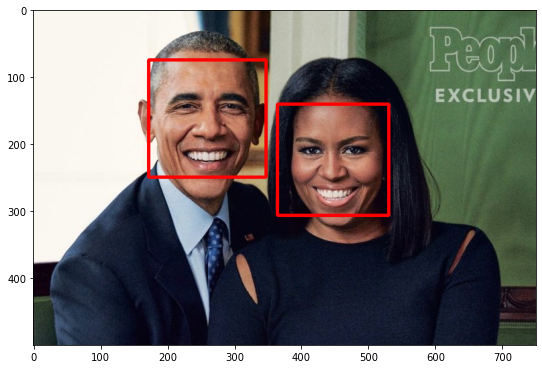

In [3]:
# Load pre-trained detector
face_cascade = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')

# Run detector and store output (anchor and dimensions box) in `faces`
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# Duplicate the sample image for this example
image_with_detections = image.copy()

# For each face found
for (x,y,w,h) in faces:
    # Draw red box
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## 3.2 Load Trained Model

As before, this project used to be multiple notebooks. So, loading the model again isn't necessary anymore, but it's always good to see the full process.

In [4]:
import torch
from models import Net

net = Net()

# Load model checkpoint into network
net.load_state_dict(torch.load('models/keypoints_model_1.pt'))

# Print network to be sure
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=30976, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

## 3.3 Keypoint Detection

This time, when I loop over the faces in the sample image, I will transform the selection according to what the network expects; once again, that's a grayscale Tensor of size 224x224 with normalized color channels. The transforms will be the same ones from `data_load.py` that I have already used several times.

Udacity provides this helpful hint for how to handle faces that varying significantly from the size the model expects:

>**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

Finally, the image can be passed through the network, and hopefully something like this will emerge:

<img src='images/michelle.png' width="100%" height="auto" style="max-width: 400px;"/>




In [5]:
def show_all_keypoints(image, keypoints):
    """Show image with predicted keypoints"""
    
    plt.figure(figsize=(5, 5))
               
    keypoints = keypoints.data.numpy()
    keypoints = keypoints * 60.0 + 96
    keypoints = np.reshape(keypoints, (68, 2))
    
    image = image.squeeze(0)
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    image = np.squeeze(image)
    
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')

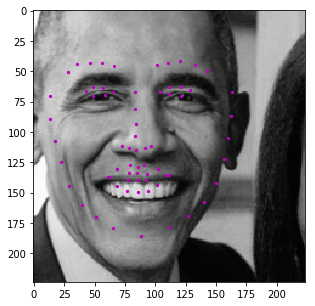

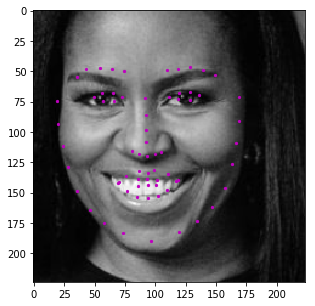

In [6]:
image_copy = np.copy(image)

# For each face found
for (x,y,w,h) in faces:
    
    # Tighten crop
    w = int(w * 1.25)
    h = int(h * 1.25)
    
    # Select facial region of interest
    roi = image_copy[y:y+h, x:x+w]
    
    # Convert to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    # Downscale color range from 0-255 to 0-1
    roi = roi / 255.0
    
    # Rescale to 224x224
    roi = cv2.resize(roi, (224, 224))
    
    # Swap color axis, because
    # NumPy image: H x W x C
    # Torch image: C X H X W
    roi = np.reshape(roi, (1, 1, 224, 224))
    
    # Pass through network
    roi = torch.from_numpy(roi)
    roi = roi.type(torch.FloatTensor)
    keypoints = net(roi)

    # Plot result
    show_all_keypoints(roi, keypoints)

That looks pretty good!

But I do see further examples of the model overfitting, like how the points aren't elastic enough to accomodate Barack's beautiful chin.

# 4.0 Facial Filters

Alright, friends – the network can detect facial keypoints, and it can now detect faces! There remains only one thing left to do before the singularity can begin: the network must be capable of putting *"Deal With It"* sunglasses on any detected face! Here's what I'm shooting for:


<img src='images/filter.png' width="100%" height="auto" style="max-width: 800px;"/>

First, the sunglasses...

In [1]:
# Import packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


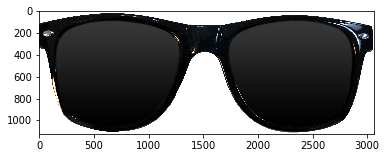

In [2]:
# Load sunglasses with cv2 and IMREAD_UNCHANGED
# Specifying IMREAD_UNCHANGED includes alpha channel
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# Plot image
plt.imshow(sunglasses)

# Print dimensions
print('Image shape: ', sunglasses.shape)

The alpha channel looks like this (black pixels = transparent): 


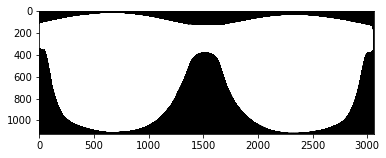

In [3]:
# Print image alpha
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [4]:
# Print non-zero values on alpha channel
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


## 4.1 Overlay Sunglasses

Like me, you might recognize the concept of an alpha channel from Photoshop. But, now, that channel has a novel use: the network can use that channel to decide which pixels from the sunglasses image (all pixels with alpha > 0) should be overlaid on the face image and, once scaled, where they should be placed relative to the image anchor.

The last puzzle to solve will be how to place that anchor...


Let's flashback to the example of numbered facial keypoints:

<img src='images/keypoints.png' width="100%" height="auto" style="max-width: 800px;"/>

Using this example as the key, everything from eye width to nose length can be calculated programatically! It will require some calibration to figure out exactly how sunglasses fit on someone's face; but, once the variables have been nailed down, no face will be safe!

But there will be one important hitch to remember: the numbers above **are off by one**, because the keypoint array will begin with `keypoint[0]`.

Now, I gotta grab some keypoints and start calibrating...

In [6]:
# Load training data
keypoints_frame = pd.read_csv('/data/training_frames_keypoints.csv')

# Confirm number of images
print('Number of images: ', keypoints_frame.shape[0])

Number of images:  3462


In [7]:
# Helper function provided by Udacity
def show_keypoints(image, keypoints):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')

Image name:  Christopher_Walken_01.jpg


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


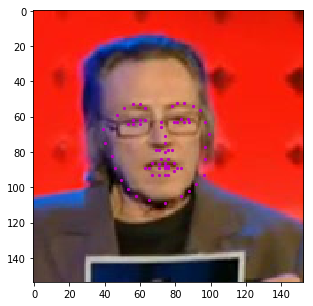

In [8]:
# Select image (n = 120 is Christopher Walken) and get keypoints
n = 120
image_name = keypoints_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('/data/training/', image_name))
keypoints = keypoints_frame.iloc[n, 1:].as_matrix()
keypoints = keypoints.astype('float').reshape(-1, 2)

# Print image name
print('Image name: ', image_name)

# Plot image
plt.figure(figsize=(5, 5))
show_keypoints(image, keypoints)
plt.show()

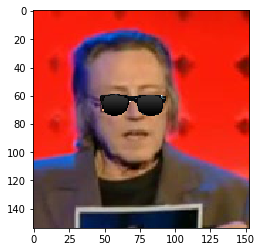

In [9]:
# Duplicate image
image_copy = np.copy(image)

# Set sunglasses anchor
# 17 = outter edge of left eyebrow
x = int(keypoints[17, 0])
y = int(keypoints[17, 1])

# Set height and width of sunglasses
# h = length of nose
h = int(abs(keypoints[27,1] - keypoints[34,1]))
# w = total width of eyebrows
w = int(abs(keypoints[17,0] - keypoints[26,0]))

# Read in sunglasses image
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# Resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# Get region of interest
roi_color = image_copy[y:y+h,x:x+w]

# Get all pixels where alpha > 0
pos_alpha = np.argwhere(new_sunglasses[:,:,3] > 0)

# Replace pixels in original image with sunglasses pixels of alpha > 0
for i in range(3):
    roi_color[pos_alpha[:,0],pos_alpha[:,1],i] = new_sunglasses[pos_alpha[:,0],pos_alpha[:,1],i]    
image_copy[y:y+h,x:x+w] = roi_color

# Plot image
plt.imshow(image_copy)

Heck yeah! Data science!

Made by <a href="https://github.com/SeanvonB">SeanvonB</a> | <a href="https://github.com/SeanvonB/facial-keypoint-detector">Source</a>